# **PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle**

# *Описание проекта*

Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.
Вам поставлена задача создать такую модель.

# Какой кейс решаем
Задача состоит из пяти основых шагов:
1. Удаление строковых значений.
2. Очистка от пропущенных значений. 
3. Создание новых признаков.
4. Преобразование признаков.
5. Отбор признаков.

При помощи этих шагов требуется повысить качество предсказания. Чтобы понять, что качество улучшилось, необходимл ориентироваться на метрику MAPE.

# **Исходные данные**

In [9]:
# инструменты анализа и обработки данных
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import category_encoders as ce # импортируем библиотеку для работы с кодировщиками
import re

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Библиотеки для анализа тональности текста
#!pip install nltk[twitter]
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# для нормализации, стандартизации
from sklearn import preprocessing

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [10]:
# Фиксация RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [11]:
# Фиксация версии пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [12]:
# Подгрузим наши данные из соревнования

df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн

In [13]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
hotels.head(2)

C:\Users\glaz\AppData\Local\Temp\ipykernel_13604\158525164.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0


In [14]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# **1. Удаление строковых значений.**

К типу object (строковые и дата/время) отностятся признаки:
* hotel_address (адрес отеля);
* review_date (дата, когда рецензент разместил соответствующий отзыв);
* hotel_name (название отеля);
* reviewer_nationality (страна рецензента);
* negative_review (отрицательный отзыв, который рецензент дал отелю);
* positive_review (положительный отзыв, который рецензент дал отелю);
* tags (теги, которые рецензент дал отелю);
* days_since_review (количество дней между датой проверки и датой очистки).

Название отеля скорее всего не должно влиять на рейтинг отеля.
Количество дней между датой проверки и датой очистки не относится к действиям рецензента.
По всем остальным признакам есть смысл обработки.

# *1.1 Обработка "hotel_address"*
Есть смысл проанализировать, является ли рецензент резедентом страны, в которой расположен отель.

In [15]:
#Выполнив визуальный анализ:
# - 50-ти первых и последних уникальных адресов,
# - широт, округленных до целого: [52, 49, 45, 51, 48, 41, 46],
# - долготы, округленных до целого: [ 0,  2,  5,  9, 16]
#можно предположить, что все отели расположены в 6-ти городах: Амстердам, Барселона, Вена, Лондон, Милан, Париж.

#Создадим признак 'resident', для которых 1 - рецензент является резедентом страны, в которой расположен отель, 
#                                         0 - рецензент не является резедентом страны, в которой расположен отель

def city_def(address):
     #*****
    #Функция выдает наименование страны, в которой расположен отель
    #Аргументы: address - адрес отеля
    #*****
    if 'Amsterdam' in address:
        return 'Netherlands'
    elif 'Barcelona' in address:
        return 'Spain'
    elif 'Vienna' in address:
        return 'Austria'
    elif 'London' in address:
        return 'UnitedKingdom'
    elif 'Milan' in address:
        return 'Italy'
    elif 'Paris' in address:
        return 'France'
    else: return '0'

#Выполняем замену адреса: вместо полного адреса указываем страну, в которой расположен отель    
hotels['hotel_address'] = hotels['hotel_address'].apply(lambda x: city_def(x))

#Уберем пробелы в названии страны резедента
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.replace(" ", ""))

#Создадим признак 'resident'
hotels['resident'] = np.where(hotels['hotel_address'] == hotels['reviewer_nationality'], 1, 0)

hotels[['hotel_address','reviewer_nationality','resident']][:10]

,hotel_address,reviewer_nationality,resident
0,Italy,UnitedKingdom,0
1,Netherlands,Belgium,0
2,Spain,Sweden,0
3,Italy,UnitedStatesofAmerica,0
4,Netherlands,UnitedKingdom,0
5,UnitedKingdom,Ecuador,0
6,UnitedKingdom,UnitedKingdom,1
7,UnitedKingdom,Netherlands,0
8,France,Ireland,0
9,UnitedKingdom,Canada,0


# *1.2 Обработка "review_date"*
Однозначно можно говорить, что плюсы/минусы отеля могут проявляться в разные сезоны/месяцы. Не смотря на то, что название месяца люди нумерют, эта нумерация все-таки на уровне договоренностей; признак месяца не является порядковым. И логично предположить, что здесь лучше использовать однократное кодирование. Тем не менее, при проверке оказалось, что качество предсказания лучше при порядковом кодировании.

In [16]:
#Выделяем признак месяца "month"
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['month'] = hotels['review_date'].dt.month
hotels[['hotel_name','review_date','month']][:3]

,hotel_name,review_date,month
0,Hotel Da Vinci,2017-07-21,7
1,Urban Lodge Hotel,2016-12-12,12
2,Alexandra Barcelona A DoubleTree by Hilton,2015-11-26,11


# *1.3 Обработка "reviewer_nationality"*
Вполне возможно, что национальность рецензента может влиять на расположение (страну) отеля, например, отношение в целом к стране или городу.

In [17]:
#Закодируем страну рецензента
#Запустив последовательно варианты кодирования (порядковое, ONE-HOT ENCODING, бинарное), лучшая оценка была в однократном кодировании.

encoder = ce.OneHotEncoder(cols=['reviewer_nationality'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin], axis=1)

hotels.iloc[:10,20:25]

,reviewer_nationality_UnitedKingdom,reviewer_nationality_Belgium,reviewer_nationality_Sweden,reviewer_nationality_UnitedStatesofAmerica,reviewer_nationality_Ecuador
0,1,0,0,0,0
1,0,1,0,0,0
2,0,0,1,0,0
3,0,0,0,1,0
4,1,0,0,0,0
5,0,0,0,0,1
6,1,0,0,0,0
7,0,0,0,0,0
8,0,0,0,0,0
9,0,0,0,0,0


Общий вывод по обработке "reviewer_nationality".
Для данного варианта порядковое кодировнаие не подойдет, так как признак не является порядковым. 
При количестве стран рецензента - 225 - способ кодирования "ONE-HOT ENCODING" значительно нагружает память и увеличивает время обработки.
Удобнее, в данном случае, было бы использовать бинарное кодирование.
Но однократное кодирование показывает лучшее качество; именно поэтому "ONE-HOT ENCODING" взят за основу кодирования.
Была гипотиза уменьшить количество признаков, например, выбрав первые 10-20 стран, наиболее часто встречающихся в базе; но это уменьшало BEST SCORE в соревновании.

# *1.4 Обработка "negative_review" и "positive_review"*
Есть смысл посмотреть тональность текста отзывов

In [18]:
# Для каждого отзыва сделаем по четыре признака, описывающие оценки тональности по следующим категориям: 
# отрицательный (neg), нейтральный (neu), положительный (pos), составной (compound) (вычисляется путем нормализации приведенных оценок)

sent_analyzer = SentimentIntensityAnalyzer()

dict_neg = dict() #словарь, описывающий тональность каждого негативного отзыва
dict_pos = dict() #словарь, описывающий тональность каждого позитивного отзыва

#Заполним словарь, описывающий тональность каждого негативного отзыва
for i in hotels['negative_review']:    
    if i not in dict_neg:
        if i == 'No Negative': #При отсутствии негативного отзыва обнулим оценки, чтобы не влияли 
            analyzer = {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
        else:
            analyzer = sent_analyzer.polarity_scores(i)
        dict_neg[i] = analyzer

#Заполним словарь, описывающий тональность каждого позитивного отзыва
for i in hotels['positive_review']:    
    if i not in dict_pos:
        if i == 'No Positive': #При отсутствии позитивного отзыва обнулим оценки, чтобы не влияли
            analyzer = {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
        else:
            analyzer = sent_analyzer.polarity_scores(i)
        dict_pos[i] = analyzer
    
def dict_neg_analyzer(text, relation):
    #*****
    #Функция выдает значение/оценку конкретной категории негативного отзыва
    #Аргументы: text - текст негативного отзыва; relation - категория
    #*****
    dict_x = dict_neg[text]
    return dict_x[relation]

def dict_pos_analyzer(text, relation):
    #*****
    #Функция выдает значение/оценку конкретной категории позитивного отзыва
    #Аргументы: text - текст позитивного отзыва; relation - категория
    #*****
    dict_x = dict_pos[text]
    return dict_x[relation]

hotels['neg_neg'] = hotels['negative_review'].apply(lambda x: dict_neg_analyzer(x, 'neg'))
hotels['neg_neu'] = hotels['negative_review'].apply(lambda x: dict_neg_analyzer(x, 'neu'))
hotels['neg_pos'] = hotels['negative_review'].apply(lambda x: dict_neg_analyzer(x, 'pos'))
hotels['neg_compound'] = hotels['negative_review'].apply(lambda x: dict_neg_analyzer(x, 'compound'))
hotels['pos_neg'] = hotels['positive_review'].apply(lambda x: dict_pos_analyzer(x, 'neg'))
hotels['pos_neu'] = hotels['positive_review'].apply(lambda x: dict_pos_analyzer(x, 'neu'))
hotels['pos_pos'] = hotels['positive_review'].apply(lambda x: dict_pos_analyzer(x, 'pos'))
hotels['pos_compound'] = hotels['positive_review'].apply(lambda x: dict_pos_analyzer(x, 'compound'))

hotels[['hotel_name','negative_review','neg_neg','neg_neu','neg_pos','neg_compound','positive_review','pos_neg','pos_neu','pos_pos','pos_compound']][:10]

,hotel_name,negative_review,neg_neg,neg_neu,neg_pos,neg_compound,positive_review,pos_neg,pos_neu,pos_pos,pos_compound
0,Hotel Da Vinci,Would have appreciated a shop in the hotel th...,0.129,0.747,0.125,-0.0554,Hotel was great clean friendly staff free bre...,0.000,0.671,0.329,0.9615
1,Urban Lodge Hotel,No tissue paper box was present at the room,0.216,0.784,0.000,-0.2960,No Positive,0.000,0.000,0.000,0.0000
2,Alexandra Barcelona A DoubleTree by Hilton,Pillows,0.000,1.000,0.000,0.0000,Nice welcoming and service,0.000,0.260,0.740,0.6908
3,Hotel Principe Di Savoia,No Negative,0.000,0.000,0.000,0.0000,Everything including the nice upgrade The Hot...,0.000,0.621,0.379,0.9153
4,Hotel Esther a,No Negative,0.000,0.000,0.000,0.0000,Lovely hotel v welcoming staff,0.000,0.230,0.770,0.7717
5,Holiday Inn London Bloomsbury,They don t have free wifi,0.000,0.548,0.452,0.5106,The location is perfect if you don t have a l...,0.000,0.792,0.208,0.6124
6,Holiday Inn London Wembley,Room generally a bit shabby with some lack of...,0.066,0.855,0.080,0.1280,Location price It did not cost much more to h...,0.000,0.852,0.148,0.5106
7,Novotel London West,Executive rooms 9th Floor don t have a bath T...,0.045,0.830,0.126,0.6124,Comphy bed upgraded to executive room with ne...,0.050,0.814,0.136,0.5859
8,Hotel Saint Petersbourg Opera,Pity about the two days of rain,0.268,0.732,0.000,-0.2960,Its centrality proximity to our destination,0.000,1.000,0.000,0.0000
9,St George Hotel,Didn t like it at all construction was in pro...,0.131,0.603,0.266,0.4019,Didn t like anything about the stay if i had ...,0.089,0.711,0.200,0.3612


# *1.5 Обработка "tags"*
Из признака tags есть смысл выделить:
* количество ночей, проживших в отеле рецензентом;
* причина остановки в отеле (trip): отдых (leisure), командировка (business);
* наличие попутчиков: один (solo traveler), пара (couple), с детьми (young children, older children)

In [19]:
#Выделим в tags количество ночей
#В tags количество ночей описывается тегом "Stayed ** night", где ** - количество ночей
def find_tags(tag):
    #*****
    #Функция find_tags в списке тегов отзыва отыскивает тег, в котором есть слово "Stayed" и выделяет число - количство ночей
    #Аргумент tag - перечень тегов отзыва
    #Значение функции - количество ночей (int)
    #*****
    #Удаляем лишние символы и представлем строку в список    
    tag = tag.replace(" ' ",'').replace("' ",'').replace(" '",'').replace("[",'').replace("]",'')        
    tag = tag.strip()
    tag = tag.split(',')    
    for i in tag:        
        if i[:6] == 'Stayed':            
            return int(''.join(re.findall('\d', i)))
    return 0

hotels['stayed'] = hotels['tags'].apply(lambda x: find_tags(x))

hotels[['hotel_name','stayed']][:10]

,hotel_name,stayed
0,Hotel Da Vinci,2
1,Urban Lodge Hotel,1
2,Alexandra Barcelona A DoubleTree by Hilton,1
3,Hotel Principe Di Savoia,1
4,Hotel Esther a,2
5,Holiday Inn London Bloomsbury,1
6,Holiday Inn London Wembley,1
7,Novotel London West,3
8,Hotel Saint Petersbourg Opera,1
9,St George Hotel,2


In [20]:
#Выделим в tags причины остановки и попутчиков
def find_tags(tag, name_trip):
    #*****
    #Функция find_tags в списке тегов отзыва отыскивает запрашиваемый тег
    #Аргумент tag - перечень тегов отзыва, name_trip - запрашиваемый тег
    #Значение функции: 1 - наличие тега, 0 - отсутствие тега
    #*****
    #Удаляем лишние символы и представлем строку в список    
    tag = tag.replace(" ' ",'').replace("' ",'').replace(" '",'').replace("[",'').replace("]",'')        
    tag = tag.strip()
    tag = tag.split(',')    
    for i in tag:        
        if i == name_trip:            
            return 1
    return 0

hotels['leisure'] = hotels['tags'].apply(lambda x: find_tags(x, 'Leisure trip'))
hotels['business'] = hotels['tags'].apply(lambda x: find_tags(x, 'Business trip'))
hotels['young children'] = hotels['tags'].apply(lambda x: find_tags(x, 'Family with young children'))
hotels['older children'] = hotels['tags'].apply(lambda x: find_tags(x, 'Family with older children'))
hotels['solo traveler'] = hotels['tags'].apply(lambda x: find_tags(x, 'Solo traveler'))
hotels['couple'] = hotels['tags'].apply(lambda x: find_tags(x, 'Couple'))

hotels[['hotel_name','leisure','business','young children','older children','solo traveler','couple']][:10]

,hotel_name,leisure,business,young children,older children,solo traveler,couple
0,Hotel Da Vinci,1,0,0,0,0,1
1,Urban Lodge Hotel,1,0,0,0,0,0
2,Alexandra Barcelona A DoubleTree by Hilton,0,1,0,0,1,0
3,Hotel Principe Di Savoia,1,0,0,0,0,1
4,Hotel Esther a,0,1,0,0,1,0
5,Holiday Inn London Bloomsbury,0,1,0,0,1,0
6,Holiday Inn London Wembley,1,0,0,0,0,1
7,Novotel London West,0,1,0,0,1,0
8,Hotel Saint Petersbourg Opera,0,0,0,0,0,0
9,St George Hotel,0,0,0,0,0,1


Признаки с типом "object" удалим на следующих этапах, так как часть признаков ещё понадобятся.

# **2. Очистка от пропущенных значений.**

Пропущенные значения имеются у признаков 'lat' (широта) и 'lng' (долгота). Процент количества пропущенных значение - 0,4% (2448).
С учетом малого количества пропущенных значений есть смысл удалить строки, где имеются пропущенные значения. Правильность данного решения показывает и итоговая метрика.
Тем не менее правила конкурса требуют не удалять строки. В связи с этим для пропущенных значений выберем среднее значение широты и долготы для каждой страны/города.

In [21]:
city_list = ['Netherlands','Spain','Austria','UnitedKingdom','Italy','France'] #Список стран, в которых расположены отели
for i in city_list:
    city_lat_mean = hotels[hotels['hotel_address'] == i]['lat'].mean(axis=0,skipna=True) #среднее значение широты для страны
    city_lng_mean = hotels[hotels['hotel_address'] == i]['lng'].mean(axis=0,skipna=True) #среднее значение долготы для страны
    hotels.loc[(hotels['lat'].isnull() == True)&(hotels['hotel_address'] == i),['lat']] = city_lat_mean #заполнение пропущенного значения признака широты срденим значением
    hotels.loc[(hotels['lng'].isnull() == True)&(hotels['hotel_address'] == i),['lng']] = city_lng_mean #заполнение пропущенного значения признака долготы срденим значением

display('Количество ячеек признака lat с пропущенными значениями: ' + str(sum(hotels['lat'].isnull().values.ravel())))
display('Количество ячеек признака lng с пропущенными значениями: ' + str(sum(hotels['lng'].isnull().values.ravel())))

'Количество ячеек признака lat с пропущенными значениями: 0'

'Количество ячеек признака lng с пропущенными значениями: 0'

# 3. Создание новых признаков

На этапе 1 "Удаление строковых значений" были созданы новые признаки:
* resident - является ли рецензент резедентом страны, в которой расположен отель
* month - месяц, в котором написан отзыв
* reviewer_nationality_... - 225 признаков страны рецензента
* neg_neg, neg_neu, neg_pos, neg_compound - тональность текста негативного отзыва
* pos_neg, pos_neu, pos_pos, pos_compound - тональность текста позитивного отзыва
* stayed - количество ночей
* leisure, business - причина остановки в отеле
* young children, older children, solo traveler, couple - количество попутчиков

Выделим еще один признак: разница между количеством символов положительного и отрицательного отзыва.

In [22]:
#Визуальный анализ показал, что значения "общее количество слов" в отрицательном и положительном отзыве не корректны из-за пробелов в начале и конце текста.
#Обновим значения "review_total_negative_word_counts" и "review_total_positive_word_counts"
hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(lambda x: 0 if x == 'No Negative' else len(x.split()))
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(lambda x: 0 if x == 'No Positive' else len(x.split()))

#Создадим признак 'difference_word_counts' - разница между количеством символов положительного и отрицательного отзыва
hotels['difference_word_counts'] = hotels.apply(lambda x: x['review_total_positive_word_counts'] - x['review_total_negative_word_counts'], axis=1)

hotels[['hotel_name','review_total_positive_word_counts','review_total_negative_word_counts','difference_word_counts']][:10]

,hotel_name,review_total_positive_word_counts,review_total_negative_word_counts,difference_word_counts
0,Hotel Da Vinci,60,50,10
1,Urban Lodge Hotel,0,9,-9
2,Alexandra Barcelona A DoubleTree by Hilton,4,1,3
3,Hotel Principe Di Savoia,26,0,26
4,Hotel Esther a,5,0,5
5,Holiday Inn London Bloomsbury,24,6,18
6,Holiday Inn London Wembley,21,33,-12
7,Novotel London West,41,50,-9
8,Hotel Saint Petersbourg Opera,6,7,-1
9,St George Hotel,23,16,7


Убираем признаки, которые еще не успели обработать. 
Модель на признаках с dtypes "object" и dtypes "datetime64" обучаться не будут, просто выберим их и удалим.



In [23]:
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True) #удаляем признак с типом object
hotels.drop(hotels.columns[[1]], axis = 1, inplace=True) #удаляем признак с типом datetime64

hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Columns: 255 entries, additional_number_of_scoring to difference_word_counts
dtypes: float64(12), int32(1), int64(242)
memory usage: 1001.4 MB


# 4. Преобразование признаков

Рассмотрим признаки, которые есть смысл рассмотреть на предмет преобразования (нормализации, стандартизации):
1. difference_word_counts
2. review_total_positive_word_counts
3. review_total_negative_word_counts
4. average_score
5. total_number_of_reviews_reviewer_has_given
6. total_number_of_reviews
7. additional_number_of_scoring
8. lat
9. lng

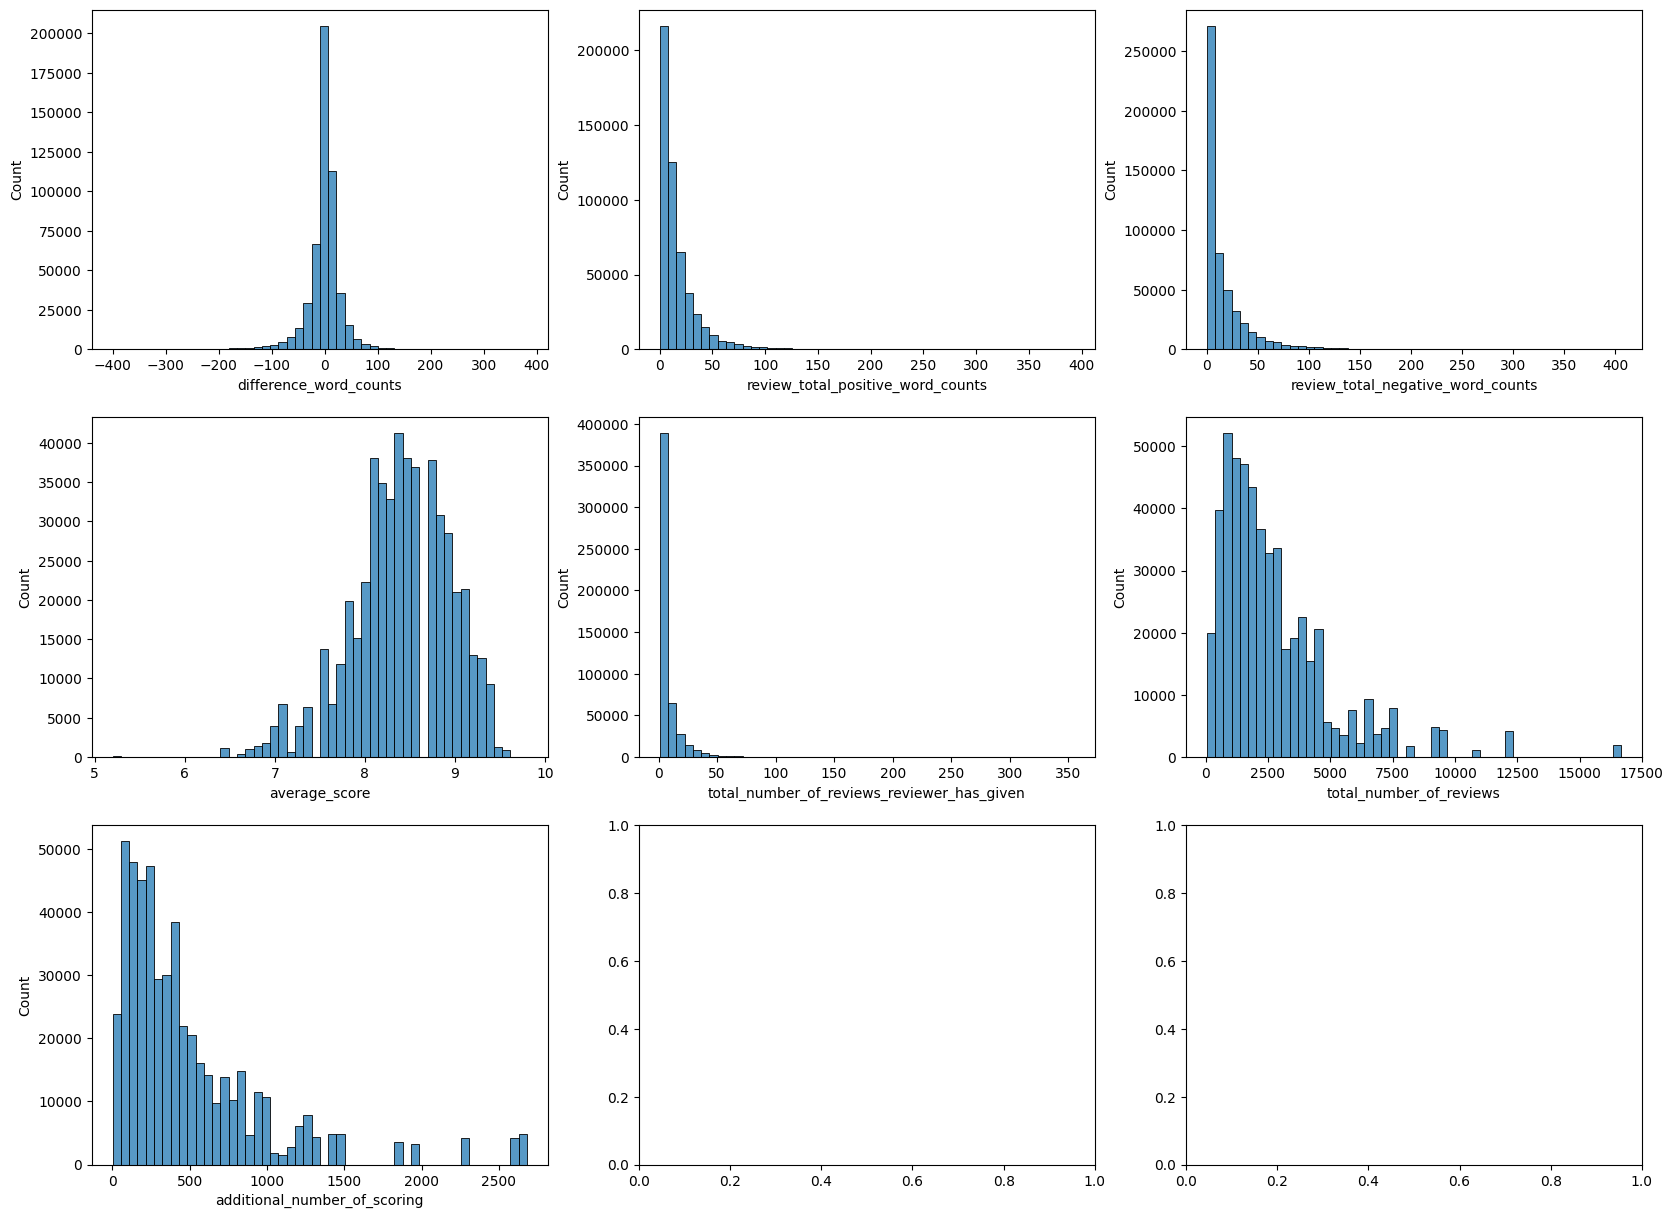

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
sns.histplot(
    data=hotels,
    x='difference_word_counts',
    bins=50,   
    ax=axes[0][0]
);
sns.histplot(
    data=hotels,
    x='review_total_positive_word_counts',
    bins=50,
    ax=axes[0][1]
);
sns.histplot(
    data=hotels,
    x='review_total_negative_word_counts',
    bins=50,
    ax=axes[0][2]
);
sns.histplot(
    data=hotels,
    x='average_score',
    bins=50,
    ax=axes[1][0]
);
sns.histplot(
    data=hotels,
    x='total_number_of_reviews_reviewer_has_given',
    bins=50,
    ax=axes[1][1]
);
sns.histplot(
    data=hotels,
    x='total_number_of_reviews',
    bins=50,
    ax=axes[1][2]
);
sns.histplot(
    data=hotels,
    x='additional_number_of_scoring',
    bins=50,
    ax=axes[2][0]
);

По данным графиков можно предположить преобразования следующего вида:
1. difference_word_counts - признак распределён нормально - предлагается стандартизировать;
2. review_total_positive_word_counts - признак распределён ненормально - предлагается нормализовать;
3. review_total_negative_word_counts - признак распределён ненормально - предлагается нормализовать;
4. average_score - признак распределён близко к нормальному - предлагается стандартизировать;
5. total_number_of_reviews_reviewer_has_given - признак распределён ненормально - предлагается нормализовать;
6. total_number_of_reviews - признак распределён ненормально - предлагается нормализовать;
7. additional_number_of_scoring - признак распределён ненормально - предлагается нормализовать.

По факту:
1. итоговая метрика подтвердила пункты 1-4;
2. нормализация признаков выполнялась на базе MinMaxScaler() и RobustScaler(), луший вариант дал - MinMaxScaler();
3. признаки 5-6 уходшали качество предсказания, как при нормализации, так и при стандартизации

**НО**
Вышеуказанные результаты преобразования были выполнены при отсутствии признака reviewer_nationality и признаках его кодирования.
Сами по себе - преобразование и кодированные признаки страны рецензента - улучшают предсказание. Но вместе они ухудшают качество. Между этими способами лучший вариант, дающий наибольший BEST SCORE, - кодирование признаков страны рецензента.

*Поэтому:*
* для целей проекта Project 3 ниже в коде представлено решение для преобразования признаков, которые бы дали улучшение при отсутствии кодирования признаков страны рецензента;
* но для целей соревнования и получения наилучшего BEST SCORE код для этапа "Преобразование признаков" был закомментирован.

In [25]:
# инициализируем нормализатор MinMaxScaler
#mm_scaler = preprocessing.MinMaxScaler()
#s_scaler = preprocessing.StandardScaler()

#Стандартизация признака difference_word_counts
#hotels['difference_word_counts']  = pd.DataFrame(
#    s_scaler.fit_transform(pd.DataFrame(hotels['difference_word_counts'])),
#    columns=['difference_word_counts'])

#Нормализация review_total_negative_word_counts
#hotels['review_total_negative_word_counts']  = pd.DataFrame(
#    mm_scaler.fit_transform(pd.DataFrame(hotels['review_total_negative_word_counts'])),
#    columns=['review_total_negative_word_counts'])

#Нормализация review_total_positive_word_counts
#hotels['review_total_positive_word_counts']  = pd.DataFrame(
#    mm_scaler.fit_transform(pd.DataFrame(hotels['review_total_positive_word_counts'])),
#    columns=['review_total_positive_word_counts'])

#Стандартизация признака average_score
#hotels['average_score']  = pd.DataFrame(
#    s_scaler.fit_transform(pd.DataFrame(hotels['average_score'])),
#    columns=['average_score'])

# 5. Отбор признаков.

Используем анализ мультиколлинеарности для отбора признаков.
В виду того, что кодированные признаки reviewer_nationality значительно увеличивают варианты и ухудшают анализ, принято решение в списке оставить признаки reviewer_nationality только для стран, в которых располагаются отели.

<AxesSubplot: >

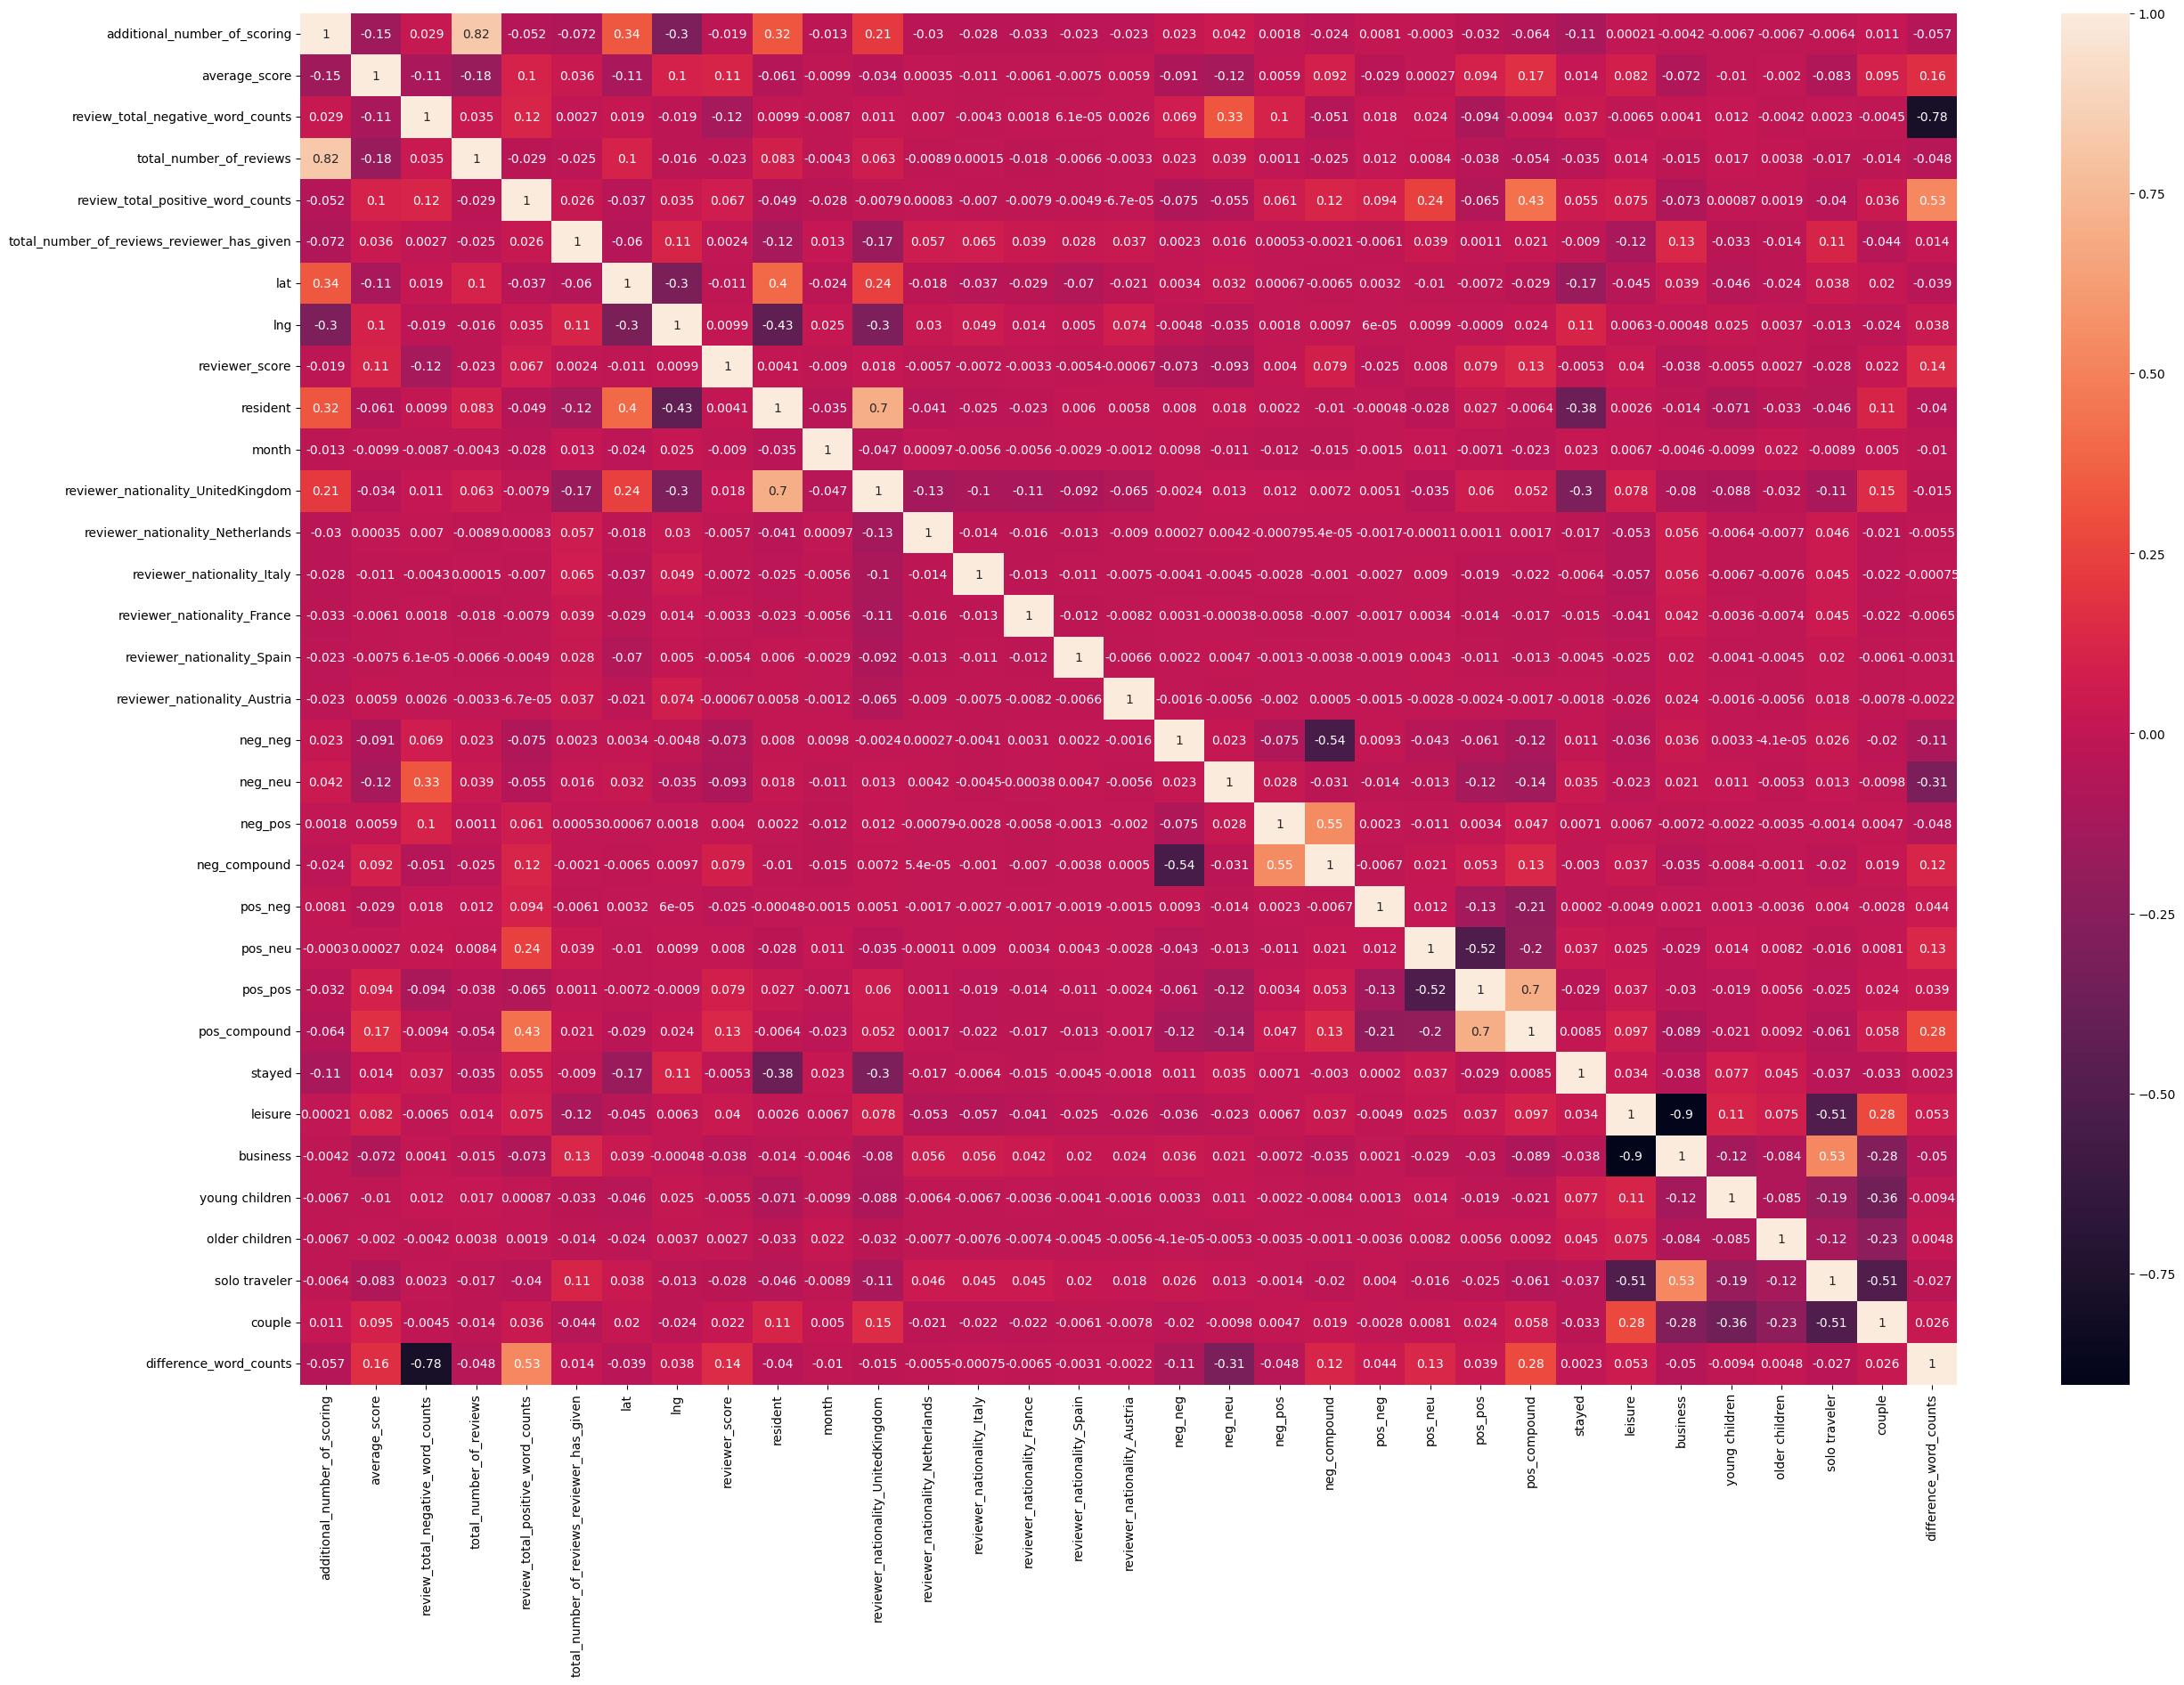

In [26]:
plt.rcParams['figure.figsize'] = (30,20)
hotels_drop = hotels.drop(['sample'], axis=1) 

#Удалим признаки reviewer_nationality, за исключением тех стран, в которых располагаются страны
nat_list_city = ['reviewer_nationality_Netherlands', 'reviewer_nationality_Spain', 'reviewer_nationality_Austria', 'reviewer_nationality_UnitedKingdom', 'reviewer_nationality_Italy', 'reviewer_nationality_France']
for col in hotels_drop.columns:
    if col[:20] == 'reviewer_nationality':
        if col not in nat_list_city:
            del hotels_drop[col]

sns.heatmap(hotels_drop.corr(), annot=True)

По данным матрицы к сильной и очень сильной корреляцией относятся пары:
* leisure - business; -0.9 очень сильная корреляция;
* review_total_negative_word_counts - difference_word_counts; -0.78 сильная корреляция;
* reviewer_nationality_UnitedKingdom - resident; 0.7 сильная корреляция

Удалим признак "business"

In [27]:
#Удалим признак "business"
hotels.drop(hotels[['business']], axis = 1, inplace=True) #удаляем признак business

hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Columns: 254 entries, additional_number_of_scoring to difference_word_counts
dtypes: float64(12), int32(1), int64(241)
memory usage: 997.5 MB


# Обучение модели и получение предсказания

Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [28]:
# Теперь выделим тестовую часть
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [29]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [30]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 253), (386803, 253), (386803, 252), (309442, 252), (77361, 252))

Создаем модель и получаем предсказание

In [31]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [32]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [33]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.2s finished


In [45]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика Mean Absolute Error (MAPE); показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.8718654682961327
MAPE: 0.12477297870206956


Оценим вклад важнейших признаков в построение модели

<AxesSubplot: >

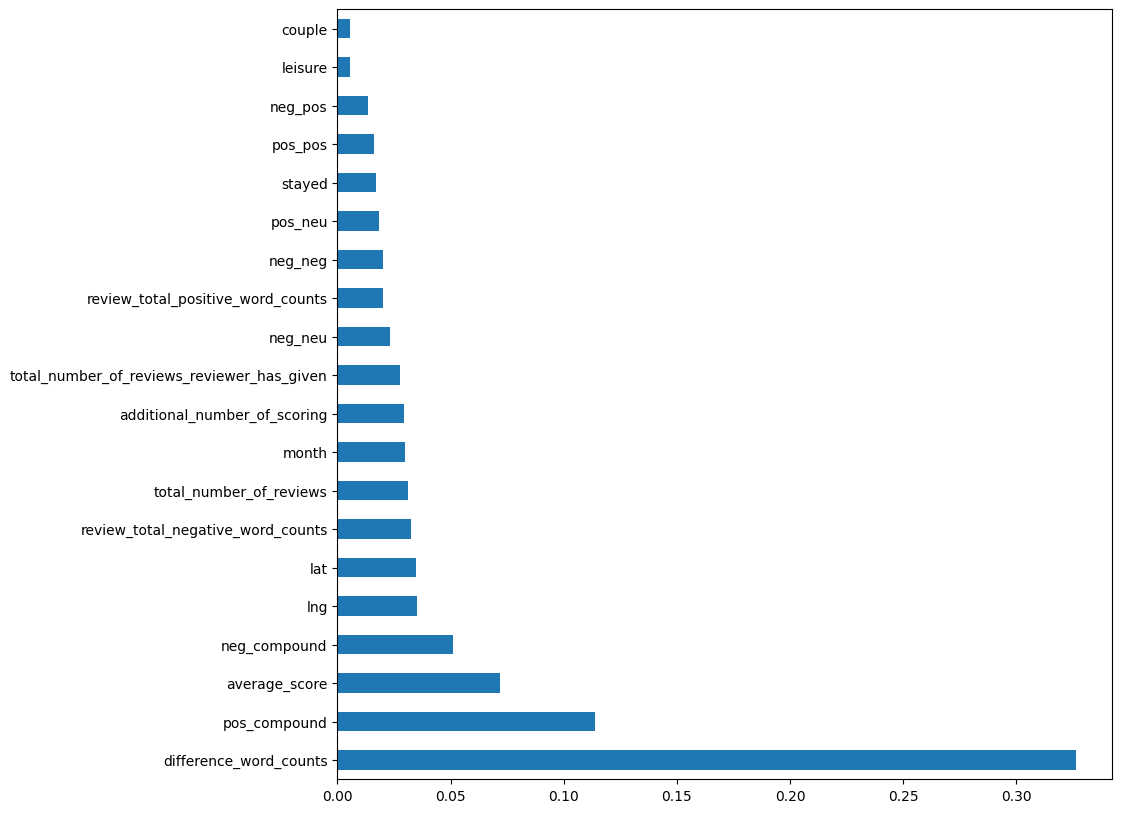

In [35]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [36]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,resident,...,pos_neu,pos_pos,pos_compound,stayed,leisure,young children,older children,solo traveler,couple,difference_word_counts
94966,528,8.7,23,2485,4,3,51.493873,-0.182496,0.0,0,...,0.476,0.524,0.5106,1,0,0,0,1,0,-19
23651,728,8.9,0,3168,12,1,51.528677,-0.128349,0.0,0,...,0.791,0.209,0.4404,1,1,0,0,1,0,12
5768,66,8.6,64,657,1,5,48.207895,16.370108,0.0,0,...,1.000,0.000,0.0000,2,1,0,0,0,0,-63
78448,457,6.8,3,2751,37,1,51.520795,-0.131084,0.0,0,...,0.754,0.246,0.8685,3,0,0,0,1,0,34
119254,248,9.2,1,945,1,1,51.542635,-0.007327,0.0,1,...,1.000,0.000,0.0000,1,1,0,0,0,1,0
49418,90,7.8,0,1544,17,4,48.843707,2.315563,0.0,0,...,0.521,0.479,0.8990,2,1,1,0,0,0,17
107316,465,8.9,19,2543,10,21,51.512246,-0.075733,0.0,0,...,0.750,0.250,0.4588,1,0,0,0,1,0,-9
111028,279,8.2,0,1140,24,1,51.492733,-0.157371,0.0,1,...,0.496,0.440,0.9165,1,0,0,0,0,0,24
67281,220,9.1,0,902,33,1,51.494308,-0.175558,0.0,0,...,0.607,0.393,0.9552,3,1,0,0,0,1,33
15961,43,7.4,38,867,24,2,41.408641,2.147814,0.0,0,...,0.587,0.413,0.9336,3,1,0,0,0,1,-14


Получаем предсказание целевой переменной

In [37]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [38]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [39]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.4s finished


In [40]:
predict_submission

array([8.721, 7.128, 9.035, ..., 8.003, 9.659, 7.062])

In [41]:
list(sample_submission)

['reviewer_score', 'id']

In [42]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.721,488440
1,7.128,274649
2,9.035,374688
3,9.707,404352
4,9.710,451596
5,8.960,302161
6,7.816,317079
7,7.611,13963
8,8.253,159785
9,7.253,195089


# Общий вывод

Итоговоая модель состоит из 254 признаков, из них 225 - признаки кодирования страны рецензента. Основной вклад в качество предсказания входили признак "разница между количеством символов положительного и отрицательного отзыва" и признаки тональности текста отзывов.

BEST SCORE - 12.55881
MAPE - 0.12477297870206956